<a href="https://colab.research.google.com/github/quantority/master-s-degree-projects/blob/main/uplift/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.metrics import make_uplift_scorer
from sklift.metrics import (uplift_at_k,
                            uplift_auc_score,
                            qini_auc_score,
                            make_uplift_scorer)
from sklift.viz import plot_qini_curve, plot_uplift_curve
from causalml.inference.tree import UpliftRandomForestClassifier
from lightgbm import LGBMClassifier
import optuna


RANDOM_STATE = 42

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=964db5e7-bfb1-4b69-81b5-3a4dd902d281
To: /content/Data.zip
100%|██████████| 289M/289M [00:03<00:00, 73.4MB/s]


'Data.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [ ]:
# ваш код здесь

df_people = pd.read_csv('PEOPLE_IN_CAMPAINGS_FINAL.csv')

In [ ]:
df_contracts = pd.read_csv('CONTRACTS_FINAL.csv')

In [ ]:
df_aggs = pd.read_csv('AGGS_FINAL.csv')

In [ ]:
df_camapaings = pd.read_csv('CAMPAINGS.csv')

In [ ]:
df = df_people.drop('Unnamed: 0', axis=1).merge(df_contracts.drop('Unnamed: 0', axis=1), on='user_id', how='left').merge(df_camapaings.drop(['Unnamed: 0', 'product_id'], axis=1), on='campaing_id')

In [ ]:
df['contract_date'] = pd.to_datetime(df['contract_date'])

In [ ]:
df['delivery_date'] = pd.to_datetime(df['delivery_date'], errors='coerce')

In [ ]:
df['target'] = df.apply(lambda row: 1 if row['t_flag'] == 1 and (row['contract_date'] - row['delivery_date']).days <= 14
                                      else (
                                          1 if row['t_flag'] == 0 and (row['contract_date'] - row['contract_date'].replace(day=1)).days <= 21
                                            else 0), axis = 1)

В задании указано, что существуют кампании с некорректными данными, найдём эти кампании, начнём с проверки того, не попали ли одни и те же пользователи в разные группы

In [ ]:
df.loc[df['user_id'].duplicated(keep=False)].sort_values(by='user_id').groupby(['channel', 't_flag'], as_index=False)['campaing_id'].count()

,channel,t_flag,campaing_id
0,push,1,60000
1,sms,0,60000


In [ ]:
df.groupby(['channel', 't_flag'])['user_id'].count()

channel    t_flag
banner     0         60000
           1         60000
other_ads  0         60000
           1         60000
push       0         80000
           1         80000
Name: user_id, dtype: int64

Одни и те же пользователи попали в разные кампании и группы. Полностью откажемся от кампании SMS и оставим пользователей для кампании PUSH

In [ ]:
df = df.loc[df['channel'] != 'sms']

Посмотрим на эффективность кампаний

In [ ]:
pivot = df.pivot_table(index='channel', columns='t_flag', values='target', aggfunc='mean', fill_value=0)

pivot['uplift'] = pivot[1] - pivot[0]

In [ ]:
pivot

t_flag,0,1,uplift
channel,,,
banner,0.400733,0.687750,0.287017
other_ads,0.400733,0.702267,0.301533
push,0.202150,0.687025,0.484875


### ваши выводы здесь

В этом блоке был создан единый датафрейм, собрано целевой действие, также на этом этапе мы определили "сломанную" кампанию и посмотрели на эффективность кампаний.

"Сломанной" оказалась кампания "SMS", из финального датасета она была удалена, а также самой эффективной кампанией оказалась кампания "push"

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [ ]:
# ваш код здесь
features = pd.read_csv('AGGS_FINAL.csv')

In [ ]:
features['report_dt'] = pd.to_datetime(features['report_dt'])

In [ ]:
september = features.loc[features['report_dt'].dt.month == 9]

In [ ]:
df['report_dt'] = '2024-09-30'

df['report_dt'] = pd.to_datetime(df['report_dt'])

In [ ]:
df_result = df.merge(september, on=['report_dt', 'user_id'])

In [ ]:
df_result.drop(['campaing_id', 'user_id', 'delivery_date', 'contract_id', 'contract_date', 'product_id', 'Unnamed: 0'], axis=1, inplace=True)

Посмотрим на распределение признаков в разрезе кампаний и групп и проведем psi тест для сравнения распределений признаков

In [ ]:
df_result.groupby(by=['channel', 't_flag']).mean(numeric_only=True)

target        x1        x2        x3        x4        x5  \
channel   t_flag                                                               
banner    0       0.400733 -0.200788 -1.005438  0.195224 -0.201540  0.005851   
          1       0.687750 -0.190153 -0.996064  0.201646 -0.199495 -0.003222   
other_ads 0       0.400733 -0.200788 -1.005438  0.195224 -0.201540  0.000000   
          1       0.702267 -0.190153 -0.996064  0.201646 -0.199495 -0.003222   
push      0       0.202150  0.604476  0.991262  0.989826 -0.606210  0.592924   
          1       0.687025  0.601202  1.004994  0.996935 -0.596487  0.601505   

                        x6        x7        x8        x9        age  
channel   t_flag                                                     
banner    0      -0.000878  0.335597  0.333879 -0.231895  32.531317  
          1       0.002184  0.335707  0.332511 -0.234196  32.500350  
other_ads 0      -0.000878  0.335597  0.333879 -0.231895  32.565050  
          1       0.002184  0.335707  0.332511 -0.234196  32.494200  
push      0      -0.002248 -0.002248 -0.000358  0.524898  32.504013  
          1      -0.002147 -0.004232 -0.003318  0.523636  32.448462

In [ ]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       mwburke.github.io.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / ((max - min)+1e-8)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [ ]:
for i in df_result['channel'].unique():
  print('channel:', i)
  for y in [f"x{i}" for i in range (1,9)]:
    result = calculate_psi(expected=df_result[(df_result['t_flag'] == 0)&(df_result['channel'] == i)][y],
                           actual=df_result[(df_result['t_flag'] == 1)&(df_result['channel'] == i)][y])
    print(f'psi для признака {y} равно {result}')

channel: push
psi для признака x1 равно 0.0002767697206009882
psi для признака x2 равно 0.00021561756105683059
psi для признака x3 равно 0.00018391711948021185
psi для признака x4 равно 0.000263721441935588
psi для признака x5 равно 0.00021383738927209807
psi для признака x6 равно 0.000213586268918342
psi для признака x7 равно 0.00016454908827573533
psi для признака x8 равно 0.0003232298576233026
channel: banner
psi для признака x1 равно 0.00037872141584055865
psi для признака x2 равно 0.0002739503708423826
psi для признака x3 равно 0.00017972873626892868
psi для признака x4 равно 0.00010725341374133702
psi для признака x5 равно 0.00024344837218884743
psi для признака x6 равно 0.00014394757205332174
psi для признака x7 равно 0.0004014445700175466
psi для признака x8 равно 0.00037846718566270413
channel: other_ads
psi для признака x1 равно 0.00037872141584055865
psi для признака x2 равно 0.0002739503708423826
psi для признака x3 равно 0.00017972873626892868
psi для признака x4 равно 0.0

По результатам теста сильных различий в распределениях признаков между целевой и контрольной группами по кампаниям нету за исключением признака "x5" кампании "other_ads", это означает, что есть основания считать, что целевая и контрольная группа этой кампании по этому признаку имеют стат. значимые отличия, поэтому в дальнейшем мы не будем его использовать

In [ ]:
df_push = df_result.query('channel == "push"').reset_index(drop=True)

df_banner = df_result.query('channel == "banner"').reset_index(drop=True)

df_other_ads = df_result.query('channel == "other_ads"').drop('x5', axis=1).reset_index(drop=True)

### ваши выводы здесь

В данном блоке мы собрали датасет объектов-признаков, признаки брались за сентябрь. По итогам EDA был обнаружен признак, который имеет стат. значимые отличия для контрольной и целевой группы.


<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

Для начала построим baseline для каждой кампании, попробуем несколько методов solomodel, twomodel, upliftrandomforest и classtransformation, затем по метрике qini-score выберем лучшую модель для каждой кампании попробуем подобрать гиперпараметры и сделаем скоринг пользователей получившимися моделями

In [ ]:
def solo_model_pipeline (arg):

  to_stratify = arg['target'].astype(str) + '_' + arg['t_flag'].astype(str)

  X_train, X_test, y_train, y_test = train_test_split(arg.drop(columns = ['target', 'channel', 'report_dt']),
                                                    arg['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)
  if arg is df_other_ads:
    nums = [f"x{i}" for i in range (1,9)]
    nums.remove('x5')
  else:
    nums = [f"x{i}" for i in range (1,9)]


  cats = ["city"]

  preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

  pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SoloModel(LogisticRegression(random_state=RANDOM_STATE)))
  ])


  pipeline.fit(X_train.drop(columns='t_flag'), y_train, model__treatment=X_train['t_flag'])

  uplift = pipeline.predict(X_test.drop(columns='t_flag'))

  at_k_score = uplift_at_k(y_true=y_test, uplift=uplift,
                          treatment=X_test['t_flag'],
                          strategy='by_group',
                          k=0.2)

  auc_score = uplift_auc_score(y_true=y_test, uplift=uplift,
                               treatment=X_test['t_flag'])

  print('Uplift@k:', at_k_score)

  print('AUC-score:', auc_score)

  print()
  fig, ax = plt.subplots(figsize=(10, 6))
  plot_uplift_curve(y_true=y_test,
                  uplift=pd.Series(uplift, index=X_test.index),
                  treatment=X_test['t_flag'], ax=ax)
  ax.set_title(f"Канал коммуникация: {arg['channel'][0]}")
  plt.show()

Uplift@k: 0.7145
AUC-score: 0.2730616784966104



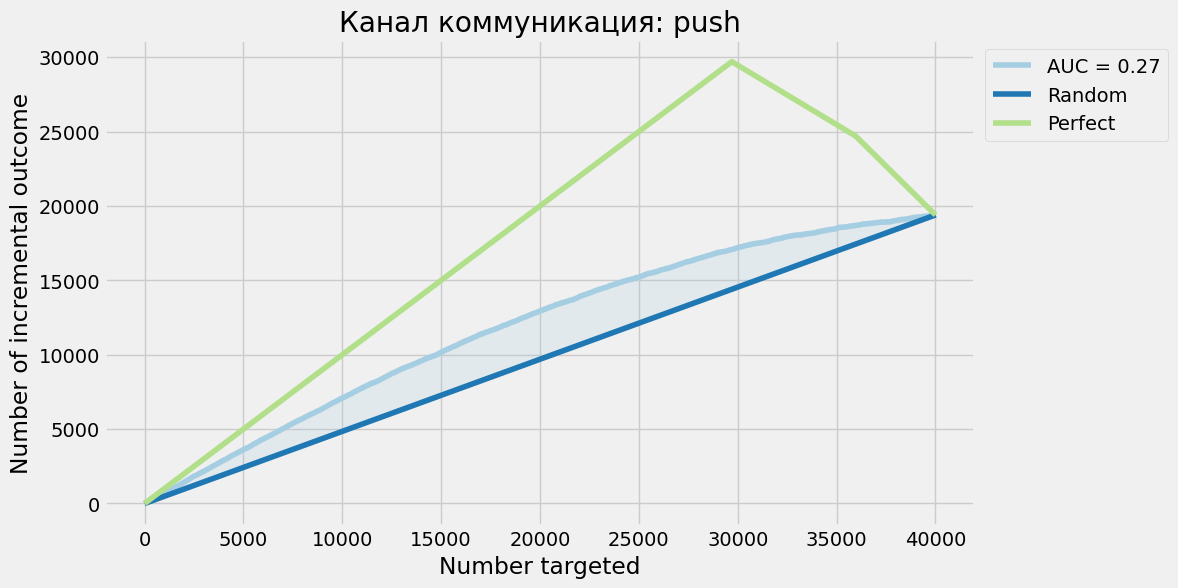

In [ ]:
solo_model_pipeline(df_push)

Uplift@k: 0.8343333333333333
AUC-score: 0.3344575307477049



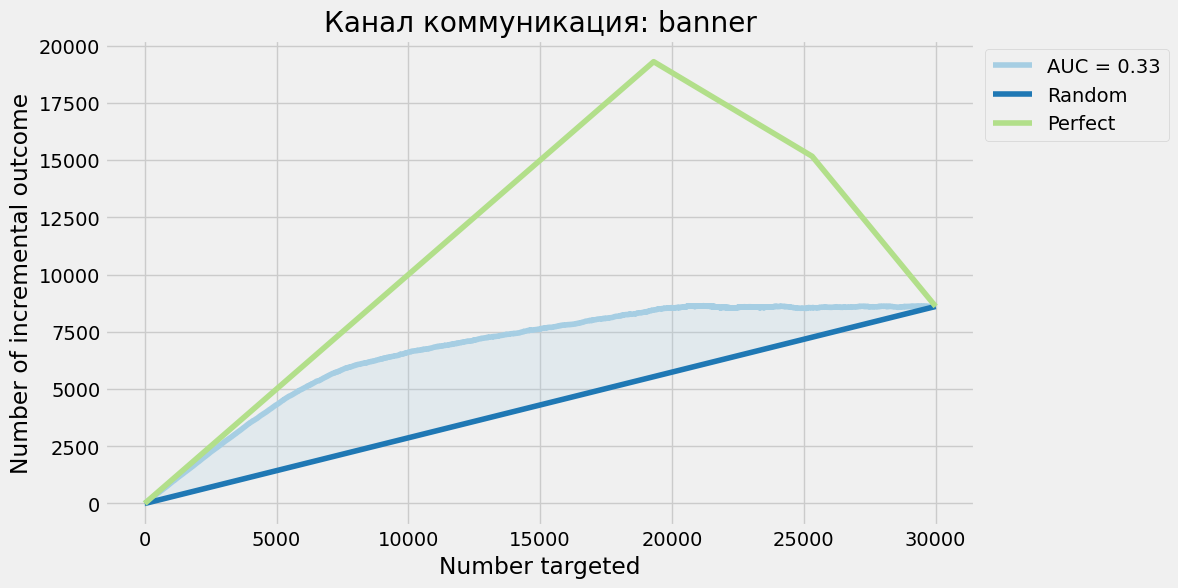

In [ ]:
solo_model_pipeline(df_banner)

Uplift@k: 0.8413333333333334
AUC-score: 0.3441873585099028



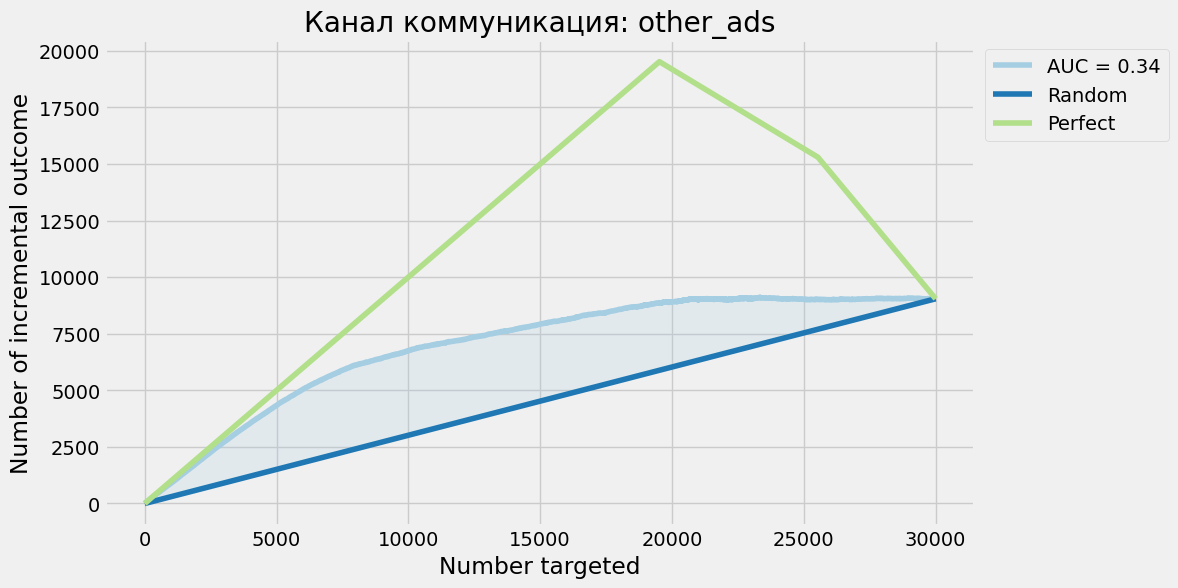

In [ ]:
solo_model_pipeline(df_other_ads)

In [ ]:
def two_models_pipeline (arg):

  to_stratify = arg['target'].astype(str) + '_' + arg['t_flag'].astype(str)

  X_train, X_test, y_train, y_test = train_test_split(arg.drop(columns = ['target', 'channel', 'report_dt']),
                                                    arg['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

  if arg is df_other_ads:
    nums = [f"x{i}" for i in range (1,9)]
    nums.remove('x5')
  else:
    nums = [f"x{i}" for i in range (1,9)]

  cats = ["city"]

  preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

  pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", TwoModels(estimator_trmnt=LogisticRegression(random_state=RANDOM_STATE),
                        estimator_ctrl=LogisticRegression(random_state=RANDOM_STATE),
                        method='vanilla'))
  ])


  pipeline.fit(X_train.drop(columns='t_flag'), y_train, model__treatment=X_train['t_flag'])

  uplift = pipeline.predict(X_test.drop(columns='t_flag'))


  at_k_score = uplift_at_k(y_true=y_test, uplift=uplift,
                          treatment=X_test['t_flag'],
                          strategy='by_group',
                          k=0.2)

  auc_score = uplift_auc_score(y_true=y_test, uplift=uplift,
                               treatment=X_test['t_flag'])

  print('Uplift@k:', at_k_score)

  print('AUC-score:', auc_score)

  print()

  fig, ax = plt.subplots(figsize=(10, 6))
  plot_uplift_curve(y_true=y_test,
                  uplift=pd.Series(uplift, index=X_test.index),
                  treatment=X_test['t_flag'], ax=ax)
  ax.set_title(f"Канал коммуникация: {arg['channel'][0]}")
  plt.show()

Uplift@k: 0.99325
AUC-score: 0.5301109336295824



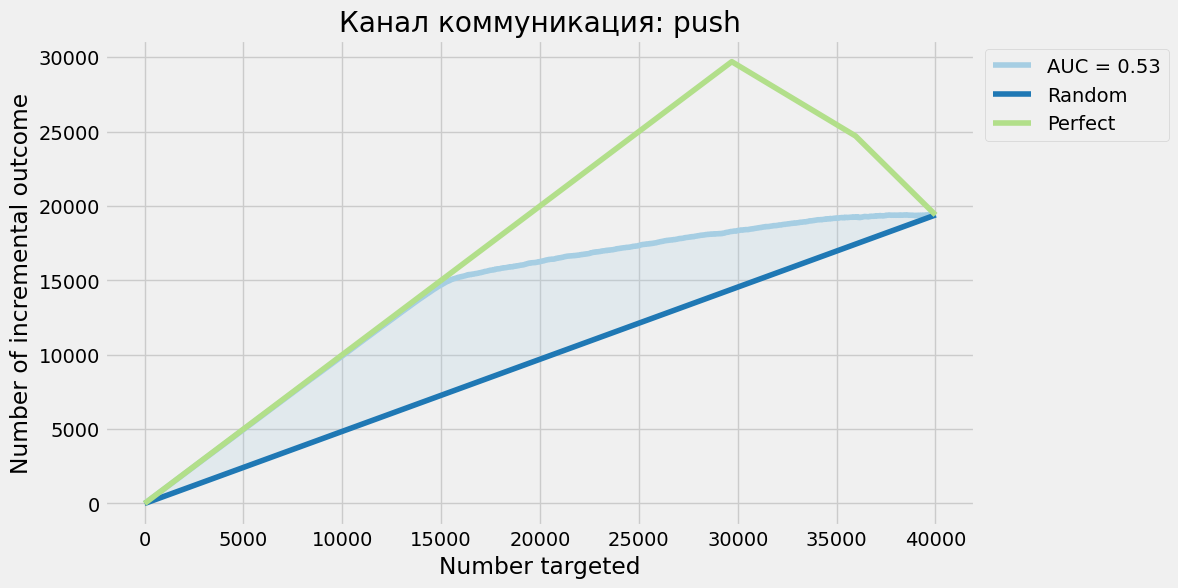

In [ ]:
two_models_pipeline(df_push)

Uplift@k: 0.9713333333333333
AUC-score: 0.36288673055908544



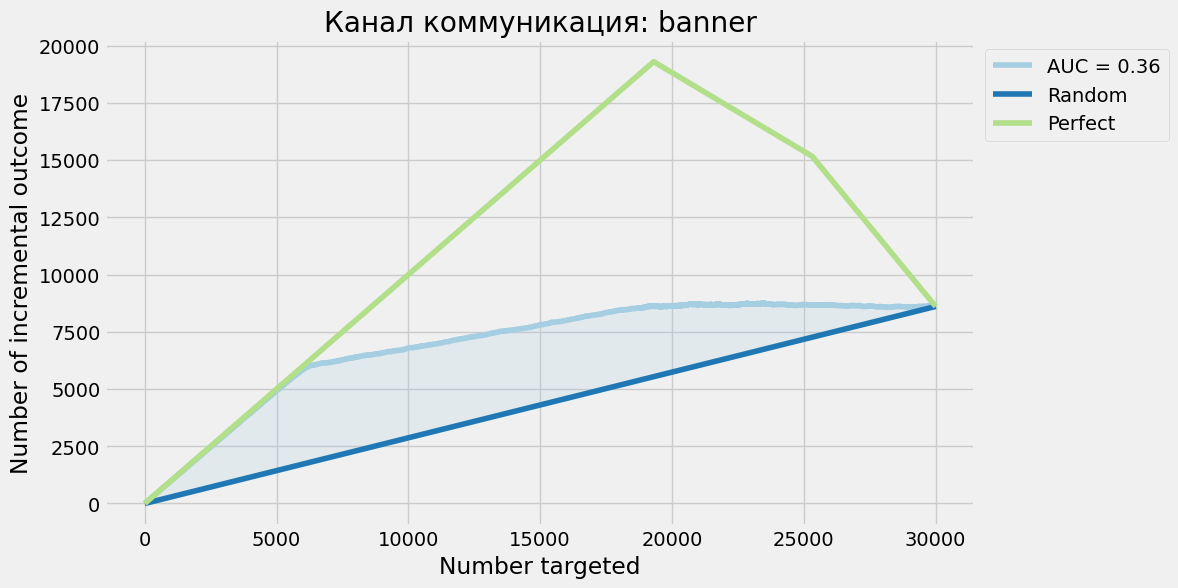

In [ ]:
two_models_pipeline(df_banner)

Uplift@k: 0.9716666666666667
AUC-score: 0.3710531497097434



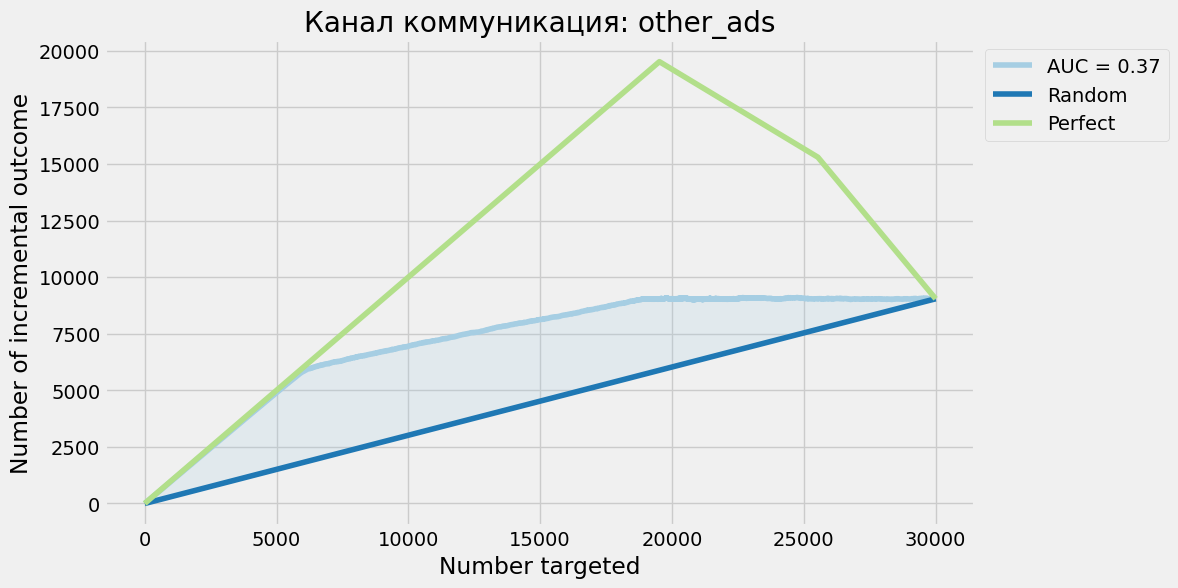

In [ ]:
two_models_pipeline(df_other_ads)

In [ ]:
def uplift_forest_pipeline (arg):

  to_stratify = arg['target'].astype(str) + '_' + arg['t_flag'].astype(str)

  X_train, X_test, y_train, y_test = train_test_split(arg.drop(columns = ['target', 'channel', 'report_dt']),
                                                    arg['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

  if arg is df_other_ads:
    nums = [f"x{i}" for i in range (1,9)]
    nums.remove('x5')
  else:
    nums = [f"x{i}" for i in range (1,9)]

  cats = ["city"]

  scaler = StandardScaler()

  X_train_scaled = scaler.fit_transform(X_train[nums])

  X_test_scaled = scaler.transform(X_test[nums])

  X_train_scaled = pd.DataFrame(X_train_scaled, columns=nums, index=X_train.index)

  X_test_scaled = pd.DataFrame(X_test_scaled, columns=nums, index=X_test.index)


  encoder = OneHotEncoder(drop='first', sparse_output=False)

  X_train_ohe = encoder.fit_transform(X_train[cats])

  X_test_ohe = encoder.transform(X_test[cats])

  X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder.get_feature_names_out(cats), index=X_train.index)

  X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder.get_feature_names_out(cats), index=X_test.index)

  X_train_preprocessed = pd.concat([X_train_scaled, X_train_ohe], axis=1).join(X_train['t_flag'])

  X_test_preprocessed = pd.concat([X_test_scaled, X_test_ohe], axis=1).join(X_test['t_flag'])

  uplift_forest = UpliftRandomForestClassifier(control_name='0',
                                             random_state=RANDOM_STATE)

  X_train_preprocessed['t_flag'] = X_train_preprocessed['t_flag'].astype('str')

  X_test_preprocessed['t_flag'] = X_test_preprocessed['t_flag'].astype('str')

  uplift_forest.fit(X=X_train_preprocessed.drop(columns='t_flag').values,
                  y=y_train.values,
                  treatment=X_train_preprocessed['t_flag'].values)

  uplift = uplift_forest.predict(X=X_test_preprocessed.drop(columns='t_flag').values)

  at_k_score = uplift_at_k(y_true=y_test, uplift=uplift.reshape(-1),
                          treatment=X_test_preprocessed['t_flag'].astype('int'),
                          strategy='by_group',
                          k=0.2)

  auc_score = uplift_auc_score(y_true=y_test, uplift=uplift.reshape(-1),
                               treatment=X_test_preprocessed['t_flag'].astype('int'))

  print('Uplift@k:', at_k_score)

  print('AUC-score:', auc_score)

  print()

  fig, ax = plt.subplots(figsize=(10, 6))
  plot_uplift_curve(y_true=y_test,
                  uplift=pd.Series(uplift.reshape(-1), index=X_test_preprocessed.index),
                  treatment=X_test_preprocessed['t_flag'].astype('int'), ax=ax)
  ax.set_title(f"Канал коммуникация: {arg['channel'][0]}")
  plt.show()

Uplift@k: 0.99
AUC-score: 0.49456636651668995



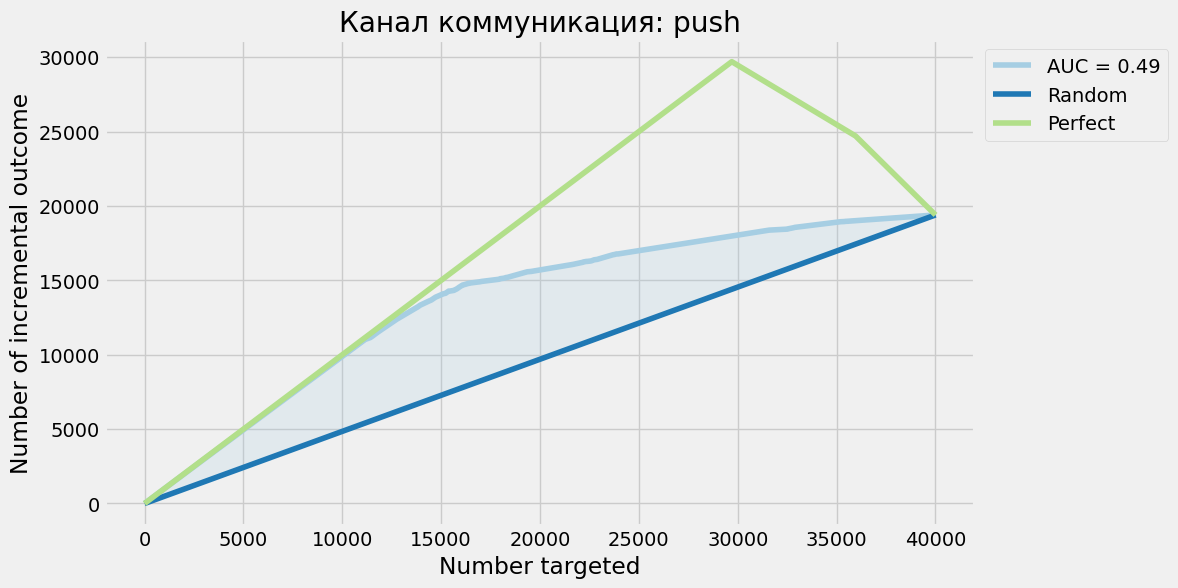

In [ ]:
uplift_forest_pipeline(df_push)

Uplift@k: 0.8576666666666667
AUC-score: 0.30512818995856666



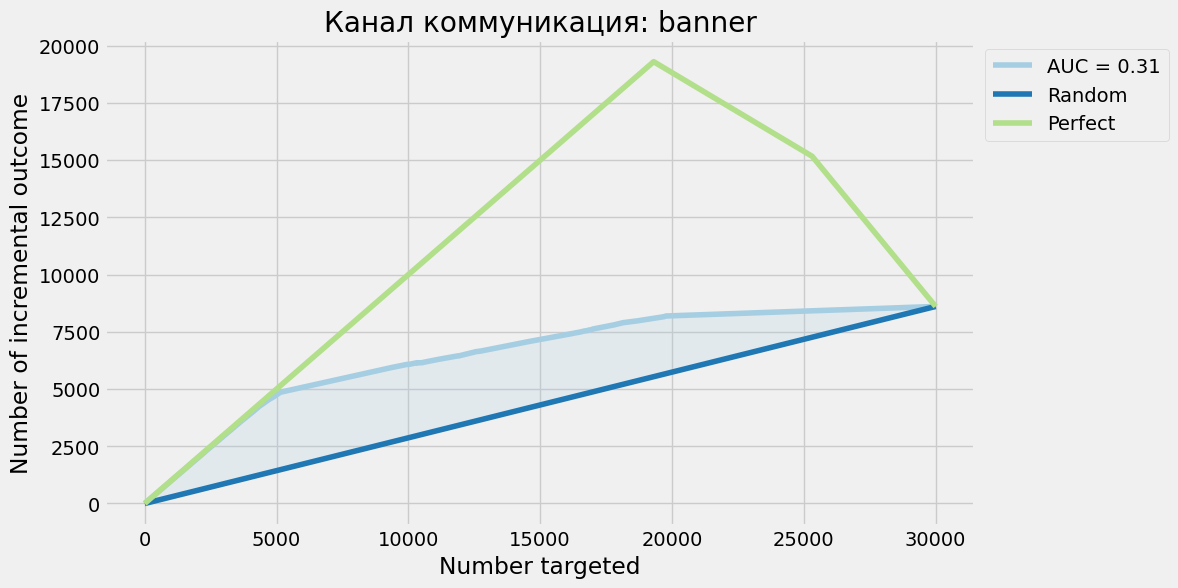

In [ ]:
uplift_forest_pipeline(df_banner)

Uplift@k: 0.8883333333333334
AUC-score: 0.3178711436884709



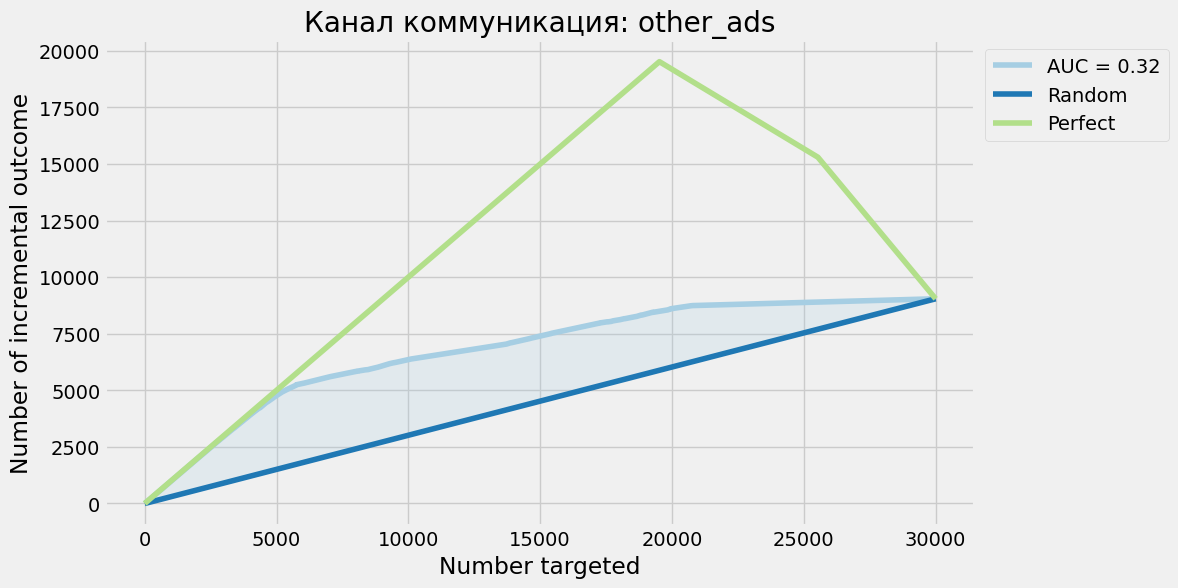

In [ ]:
uplift_forest_pipeline(df_other_ads)

In [ ]:
def ClassTransformation_model_pipeline (arg):

  to_stratify = arg['target'].astype(str) + '_' + arg['t_flag'].astype(str)

  X_train, X_test, y_train, y_test = train_test_split(arg.drop(columns = ['target', 'channel', 'report_dt']),
                                                    arg['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

  if arg is df_other_ads:
    nums = [f"x{i}" for i in range (1,9)]
    nums.remove('x5')
  else:
    nums = [f"x{i}" for i in range (1,9)]

  cats = ["city"]


  estimator = LGBMClassifier(random_state=RANDOM_STATE)

  preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

  pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ClassTransformation(estimator))
  ])


  pipeline.fit(X_train.drop(columns='t_flag'), y_train, model__treatment=X_train['t_flag'])

  uplift = pipeline.predict(X_test.drop(columns='t_flag'))

  at_k_score = uplift_at_k(y_true=y_test, uplift=uplift,
                          treatment=X_test['t_flag'],
                          strategy='by_group',
                          k=0.2)

  auc_score = uplift_auc_score(y_true=y_test, uplift=uplift,
                               treatment=X_test['t_flag'])

  print('Uplift@k:', at_k_score)

  print('AUC-score:', auc_score)

  print()

  fig, ax = plt.subplots(figsize=(10, 6))
  plot_uplift_curve(y_true=y_test,
                  uplift=pd.Series(uplift.reshape(-1), index=X_test.index),
                  treatment=X_test['t_flag'].astype('int'), ax=ax)
  ax.set_title(f"Канал коммуникация: {arg['channel'][0]}")
  plt.show()

[LightGBM] [Info] Number of positive: 89093, number of negative: 30907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742442 -> initscore=1.058698
[LightGBM] [Info] Start training from score 1.058698
Uplift@k: 0.99225
AUC-score: 0.5460608972057932



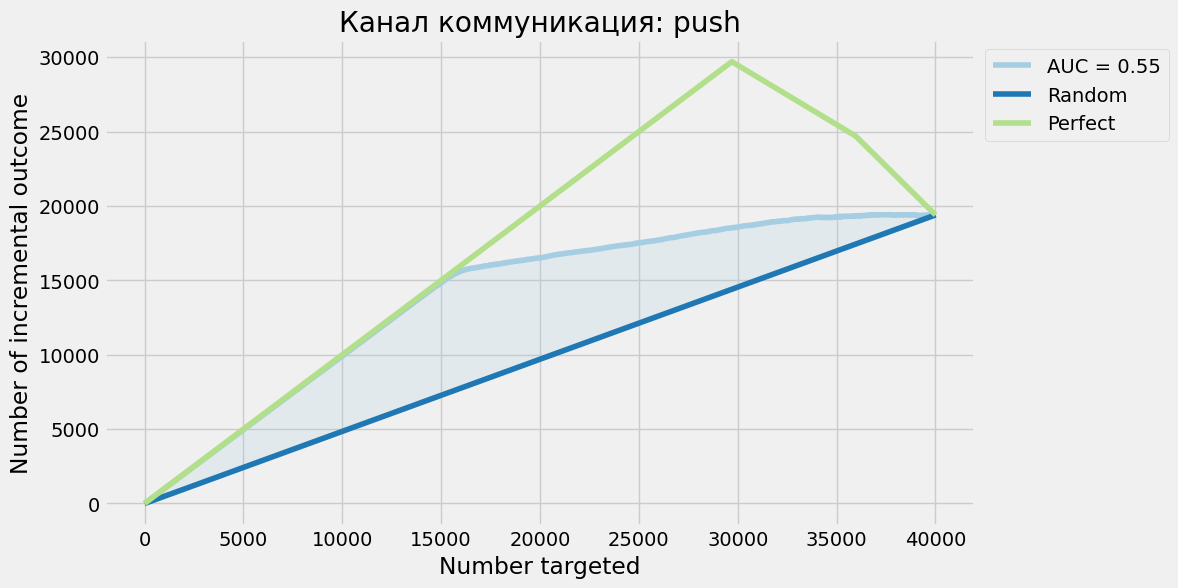

In [ ]:
ClassTransformation_model_pipeline(df_push)

[LightGBM] [Info] Number of positive: 57916, number of negative: 32084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643511 -> initscore=0.590636
[LightGBM] [Info] Start training from score 0.590636
Uplift@k: 0.9743333333333333
AUC-score: 0.36229351017502004



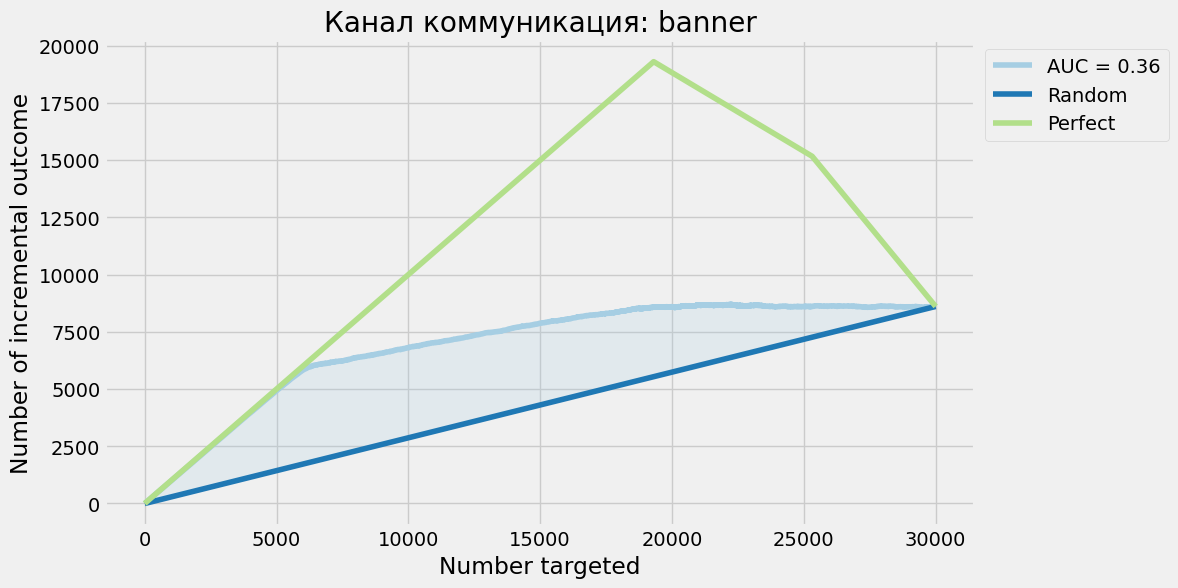

In [ ]:
ClassTransformation_model_pipeline(df_banner)

[LightGBM] [Info] Number of positive: 58569, number of negative: 31431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650767 -> initscore=0.622411
[LightGBM] [Info] Start training from score 0.622411
Uplift@k: 0.9636666666666667
AUC-score: 0.4585153647436126



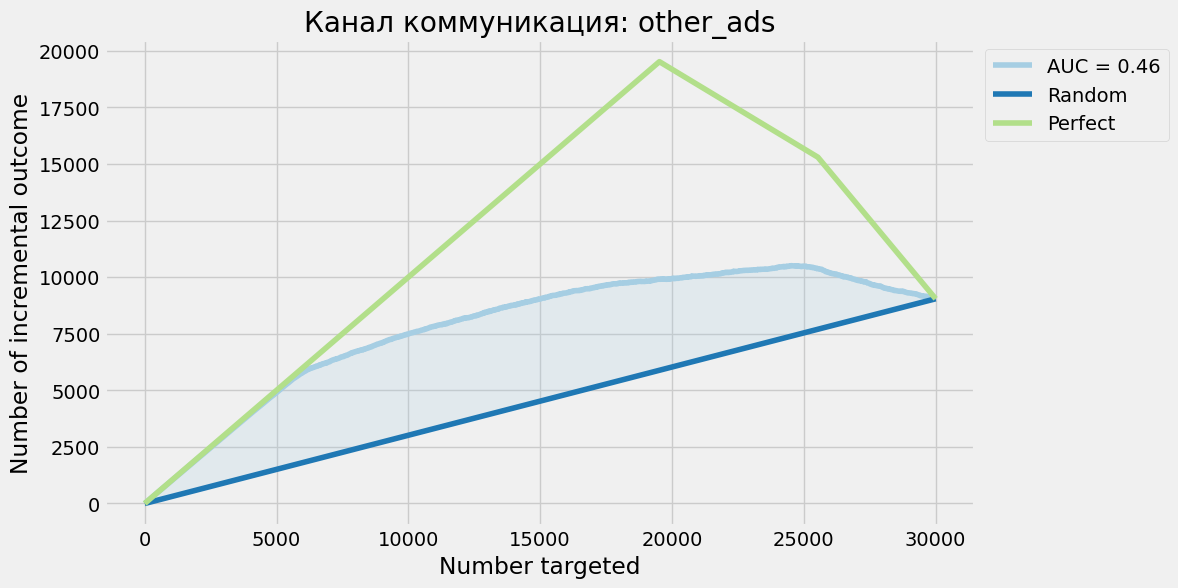

In [ ]:
ClassTransformation_model_pipeline(df_other_ads)

Baseline для каждой кампании был построен, выберем модели с лучшим скором для каждой кампании

- Push - ct+lgbmClassifier
- Banner - TM+LogisticRegression
- Other_ads - CT+lgbmClassifier

Теперь попробуем подобрать гиперпараметры для каждой модели

In [ ]:
skf = StratifiedKFold(n_splits=5,
                      random_state=RANDOM_STATE,
                      shuffle=True)

In [ ]:
def objective_ct_lgbm(trial):

    params = {
        'n_estimators':trial.suggest_categorical('n_estimators', [100, 500, 1000, 1500]),
        'max_depth':trial.suggest_int('max_depth', 5, 10),
        'num_leaves':trial.suggest_categorical('num_leaves', [10, 20, 30])
    }

    to_stratify = df_push['target'].astype(str) + '_' + df_push['t_flag'].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(df_push.drop(columns = ['target', 'channel', 'report_dt']),
                                                    df_push['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

    nums = [f"x{i}" for i in range (1,9)]
    cats = ["city"]

    estimator = LGBMClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        random_state=RANDOM_STATE, verbose=0)


    preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
    ])

    pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ClassTransformation(estimator))
    ])

    qini_scorer = make_uplift_scorer("qini_auc_score", X_train['t_flag'])

    cross_val = cross_validate(pipeline,
                               X=X_train.drop(columns='t_flag'),
                               y=y_train,
                               fit_params={'model__treatment':X_train['t_flag']},
                               scoring=qini_scorer,
                               cv=skf,
                               n_jobs=-1,
                               return_train_score=True)

    return cross_val['test_score'].mean() - cross_val['test_score'].std()

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_ct_lgbm = optuna.create_study(direction="maximize")
study_ct_lgbm.optimize(objective_ct_lgbm,
                  n_trials=100,
                  show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
ct_lgbm_params_push = study_ct_lgbm.best_params

In [ ]:
ct_lgbm_params_push

{'n_estimators': 100, 'max_depth': 7, 'num_leaves': 20}

[LightGBM] [Info] Number of positive: 89093, number of negative: 30907
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742442 -> initscore=1.058698
[LightGBM] [Info] Start training from score 1.058698
Uplift@k: 0.99225
AUC-score: 0.5463973209811063



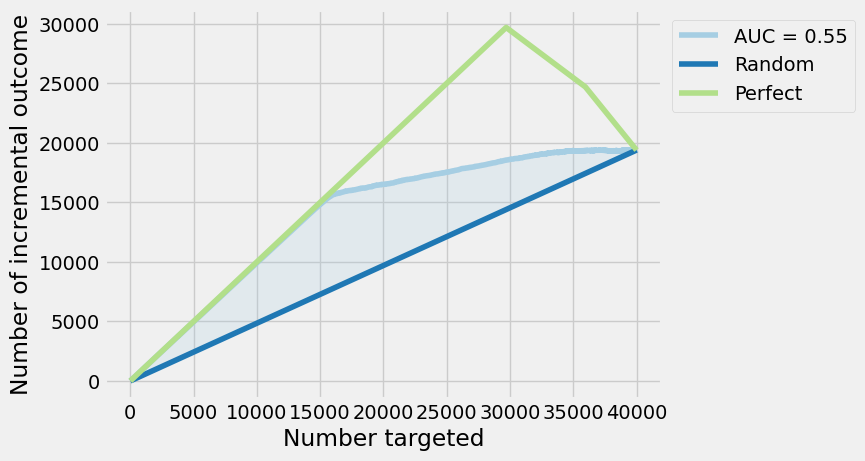

In [ ]:
  to_stratify = df_push['target'].astype(str) + '_' + df_push['t_flag'].astype(str)

  X_train, X_test, y_train, y_test = train_test_split(df_push.drop(columns = ['target', 'channel', 'report_dt']),
                                                    df_push['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

  nums = [f"x{i}" for i in range (1,9)]
  cats = ["city"]

  estimator = LGBMClassifier(random_state=RANDOM_STATE, **ct_lgbm_params_push)

  preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

  pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ClassTransformation(estimator))
  ])


  pipeline.fit(X_train.drop(columns='t_flag'), y_train, model__treatment=X_train['t_flag'])

  uplift = pipeline.predict(X_test.drop(columns='t_flag'))

  at_k_score = uplift_at_k(y_true=y_test, uplift=uplift,
                          treatment=X_test['t_flag'],
                          strategy='by_group',
                          k=0.2)

  auc_score = uplift_auc_score(y_true=y_test, uplift=uplift,
                               treatment=X_test['t_flag'])

  print('Uplift@k:', at_k_score)

  print('AUC-score:', auc_score)

  print()

  plot_uplift_curve(y_true=y_test,
                  uplift=pd.Series(uplift, index=X_test.index),
                  treatment=X_test['t_flag'])
  plt.show()

In [ ]:
def objective_tm_lr(trial):

    params = {
            'C_1':trial.suggest_loguniform('С', 0.001, 3),
            'C_2':trial.suggest_loguniform('С', 0.001, 3),
            'method':trial.suggest_categorical("method", ['vanilla', 'ddr_control', 'ddr_treatment'])
    }

    to_stratify = df_banner['target'].astype(str) + '_' + df_banner['t_flag'].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(df_banner.drop(columns = ['target', 'channel', 'report_dt']),
                                                    df_banner['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

    nums = [f"x{i}" for i in range (1,9)]
    cats = ["city"]

    preprocessor = ColumnTransformer([
      ("nums", StandardScaler(), nums),
      ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
    ])


    pipeline = Pipeline([
      ("preprocessor", preprocessor),
      ("model", TwoModels(estimator_trmnt=LogisticRegression(random_state=RANDOM_STATE+1, C=params['C_1'], verbose=0),
                          estimator_ctrl=LogisticRegression(random_state=RANDOM_STATE+2, C=params['C_2'], verbose=0),
                          method=params['method']))
    ])

    qini_scorer = make_uplift_scorer("qini_auc_score", X_train['t_flag'])

    cross_val = cross_validate(pipeline,
                               X=X_train.drop(columns='t_flag'),
                               y=y_train,
                               fit_params={'model__treatment':X_train['t_flag']},
                               scoring=qini_scorer,
                               cv=skf,
                               n_jobs=-1,
                               return_train_score=True)

    return cross_val['test_score'].mean() - cross_val['test_score'].std()

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_tm = optuna.create_study(direction="maximize")
study_tm.optimize(objective_tm_lr,
                  n_trials=150,
                  show_progress_bar=True)

  0%|          | 0/150 [00:00<?, ?it/s]

<ipython-input-279-2082511407be>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C_1':trial.suggest_loguniform('С', 0.001, 3),
<ipython-input-279-2082511407be>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C_2':trial.suggest_loguniform('С', 0.001, 3),
<ipython-input-279-2082511407be>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C_1':trial.suggest_loguniform('С', 0.001, 3),
<ipython-input-279-2082511407be>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 

In [ ]:
tm_lr_params = study_tm.best_params

In [ ]:
tm_lr_params

{'С': 2.998546992331366, 'method': 'ddr_treatment'}

Uplift@k: 0.9723333333333333
AUC-score: 0.3640261917370639



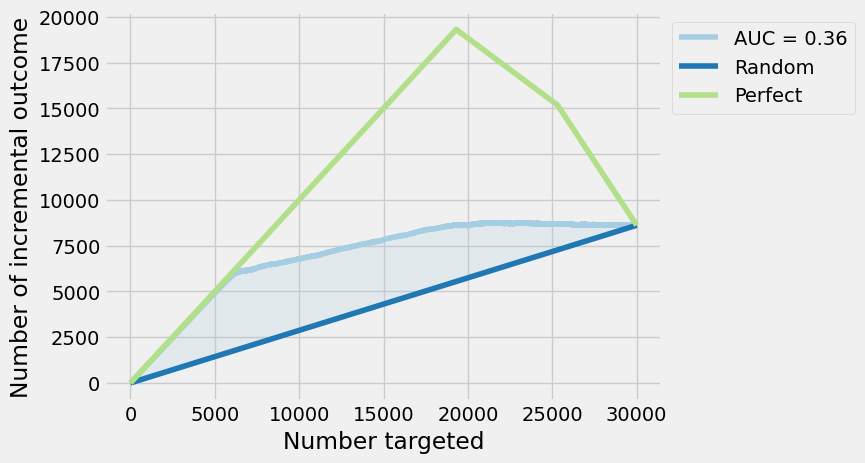

In [ ]:
  to_stratify = df_banner['target'].astype(str) + '_' + df_banner['t_flag'].astype(str)

  X_train, X_test, y_train, y_test = train_test_split(df_banner.drop(columns = ['target', 'channel', 'report_dt']),
                                                    df_banner['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

  nums = [f"x{i}" for i in range (1,9)]
  cats = ["city"]

  preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

  pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", TwoModels(estimator_trmnt=LogisticRegression(random_state=RANDOM_STATE+1, C=2.999183424857834),
                        estimator_ctrl=LogisticRegression(random_state=RANDOM_STATE+2, C=2.999183424857834),
                        method='ddr_treatment'))
  ])


  pipeline.fit(X_train.drop(columns='t_flag'), y_train, model__treatment=X_train['t_flag'])

  uplift = pipeline.predict(X_test.drop(columns='t_flag'))

  at_k_score = uplift_at_k(y_true=y_test, uplift=uplift,
                          treatment=X_test['t_flag'],
                          strategy='by_group',
                          k=0.2)

  auc_score = uplift_auc_score(y_true=y_test, uplift=uplift,
                               treatment=X_test['t_flag'])

  print('Uplift@k:', at_k_score)

  print('AUC-score:', auc_score)

  print()

  plot_uplift_curve(y_true=y_test,
                  uplift=pd.Series(uplift, index=X_test.index),
                  treatment=X_test['t_flag'])
  plt.show()

In [ ]:
def objective_ct_lgbm(trial):

    params = {
        'n_estimators':trial.suggest_categorical('n_estimators', [100, 500, 1000, 1500]),
        'max_depth':trial.suggest_int('max_depth', 5, 10),
        'num_leaves':trial.suggest_categorical('num_leaves', [10, 20, 30])
    }

    to_stratify = df_other_ads['target'].astype(str) + '_' + df_other_ads['t_flag'].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(df_other_ads.drop(columns = ['target', 'channel', 'report_dt']),
                                                    df_other_ads['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

    nums = [f"x{i}" for i in range (1,9)]
    nums.remove('x5')
    cats = ["city"]

    estimator = LGBMClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        random_state=RANDOM_STATE, verbose=0)

    preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
    ])

    pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ClassTransformation(estimator))
    ])

    qini_scorer = make_uplift_scorer("qini_auc_score", X_train['t_flag'])

    cross_val = cross_validate(pipeline,
                               X=X_train.drop(columns='t_flag'),
                               y=y_train,
                               fit_params={'model__treatment':X_train['t_flag']},
                               scoring=qini_scorer,
                               cv=skf,
                               n_jobs=-1,
                               return_train_score=True)

    return cross_val['test_score'].mean() - cross_val['test_score'].std()

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_ct_lgbm = optuna.create_study(direction="maximize")
study_ct_lgbm.optimize(objective_ct_lgbm,
                  n_trials=50,
                  show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
ct_lgbm_params_otehr_ads = study_ct_lgbm.best_params

In [ ]:
ct_lgbm_params_otehr_ads

{'n_estimators': 100, 'max_depth': 5, 'num_leaves': 30}

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

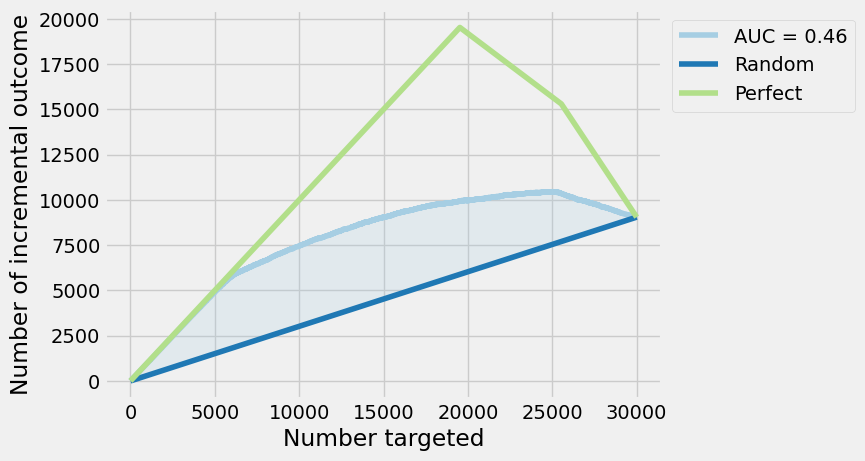

In [ ]:
  to_stratify = df_other_ads['target'].astype(str) + '_' + df_other_ads['t_flag'].astype(str)

  X_train, X_test, y_train, y_test = train_test_split(df_other_ads.drop(columns = ['target', 'channel', 'report_dt']),
                                                    df_other_ads['target'],
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)

  nums = [f"x{i}" for i in range (1,9)]
  cats = ["city"]
  nums.remove('x5')

  estimator = LGBMClassifier(random_state=RANDOM_STATE, **ct_lgbm_params_otehr_ads, verbose=0)

  preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

  pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ClassTransformation(estimator))
  ])


  pipeline.fit(X_train.drop(columns='t_flag'), y_train, model__treatment=X_train['t_flag'])

  uplift = pipeline.predict(X_test.drop(columns='t_flag'))

  at_k_score = uplift_at_k(y_true=y_test, uplift=uplift,
                          treatment=X_test['t_flag'],
                          strategy='by_group',
                          k=0.2)

  auc_score = uplift_auc_score(y_true=y_test, uplift=uplift,
                               treatment=X_test['t_flag'])

  print('Uplift@k:', at_k_score)

  print('AUC-score:', auc_score)

  print()

  plot_uplift_curve(y_true=y_test,
                  uplift=pd.Series(uplift, index=X_test.index),
                  treatment=X_test['t_flag'])
  plt.show()

Подбор гиперпараметров немного улучшил скоры моделей

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [ ]:
# ваш код здесь

df_forecast = df_aggs.loc[df_aggs['report_dt'] == '2025-01-31'].drop('Unnamed: 0', axis=1)

In [ ]:
nums = [f"x{i}" for i in range (1,9)]
cats = ["city"]
nums.remove('x5')

estimator = LGBMClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=5, num_leaves=30, verbose=0)

preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

pipeline_other_ads = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ClassTransformation(estimator))
  ])

pipeline_other_ads.fit(df_other_ads.drop(columns=['t_flag', 'target', 'channel', 'report_dt']), df_other_ads['target'], model__treatment=df_other_ads['t_flag'])

other_ads_prediction = pipeline_other_ads.predict(df_forecast)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
other_ads_uplift = pd.DataFrame(other_ads_prediction, columns=['other_ads_uplift'])

In [ ]:
nums = [f"x{i}" for i in range (1,9)]
cats = ["city"]

preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

pipeline_banner = Pipeline([
    ("preprocessor", preprocessor),
    ("model", TwoModels(estimator_trmnt=LogisticRegression(random_state=RANDOM_STATE+1, C=2.999183424857834),
                        estimator_ctrl=LogisticRegression(random_state=RANDOM_STATE+2, C=2.999183424857834),
                        method='ddr_treatment'))
  ])


pipeline_banner.fit(df_banner.drop(columns=['t_flag', 'target', 'channel', 'report_dt']), df_banner['target'], model__treatment=df_banner['t_flag'])

banner_prediction = pipeline_banner.predict(df_forecast)

In [ ]:
banner_uplift = pd.DataFrame(banner_prediction, columns=['banner_uplift'])

In [ ]:
nums = [f"x{i}" for i in range (1,9)]
cats = ["city"]

estimator = LGBMClassifier(random_state=RANDOM_STATE, **ct_lgbm_params_push)

preprocessor = ColumnTransformer([
    ("nums", StandardScaler(), nums),
    ("cats", OneHotEncoder(handle_unknown="ignore", drop='first'), cats)
  ])

pipeline_push = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ClassTransformation(estimator))
  ])


pipeline_push.fit(df_push.drop(columns=['t_flag', 'target', 'channel', 'report_dt']), df_push['target'], model__treatment=df_push['t_flag'])

push_predictions = pipeline_push.predict(df_forecast)

In [ ]:
push_uplift = pd.DataFrame(push_predictions, columns=['push_uplift'])

In [ ]:
df_forecast = df_forecast.reset_index(drop=True).join(banner_uplift).join(push_uplift).join(other_ads_uplift)

In [ ]:
def decision (row):
  banner_uplift = row['banner_uplift']

  push_uplift = row['push_uplift']

  other_ads_uplift = row['other_ads_uplift']

  max_uplift = max([banner_uplift, push_uplift, other_ads_uplift])

  if max_uplift < 0:
    return 'Dont disturb', round(max_uplift, 2)
  elif max_uplift == banner_uplift:
    return 'banner', round(max_uplift, 2)
  elif max_uplift == push_uplift:
    return 'push', round(max_uplift, 2)
  elif  max_uplift == other_ads_uplift:
    return 'other_ads', round(max_uplift, 2)

In [ ]:
df_forecast[['decision', 'uplift']] = df_forecast.apply(decision, axis=1, result_type='expand')

In [ ]:
result = df_forecast[['user_id', 'report_dt', 'decision', 'uplift']]

In [ ]:
result

,user_id,report_dt,decision,uplift
0,1066338,2025-01-31,push,0.22
1,25872,2025-01-31,other_ads,0.22
2,4107442,2025-01-31,push,0.91
3,2047420,2025-01-31,push,0.96
4,1120643,2025-01-31,Dont disturb,-0.00
...,...,...,...,...
459995,4034876,2025-01-31,other_ads,0.26
459996,114148,2025-01-31,push,0.98
459997,143255,2025-01-31,push,0.05
459998,132172,2025-01-31,push,0.83


In [ ]:
result.groupby('decision')['uplift'].mean()

,uplift
decision,
Dont disturb,-0.002195
banner,0.426156
other_ads,0.611711
push,0.749083


### ваши выводы здесь

В рамках домшнего задания была решена задча uplift, задание можно разбить на 3 этапа

- Подготовка данных

- EDA
- Подбор моделей
- Скоринг

На этапе подготовки данных была обнаружена сломанная кампания, от которой было решено отказаться и решать задачу только для трёх кампаний. На этапе EDA был обнаружен признак, который имел существенную неоднородность, который мог привести к смещению оценок. В ходе подбора моделей были подобраны разные методы для прогнозирования upift для каждой кампании. Результаты скоринга в целом совпадают с ожиданиями по влиянию кампаний, наибольший uplift имеет кампания push, за ней идёт other_ads и banner, так же были определены пользователи которым не стоит отправлять коммуникацию.